In [13]:
using MAT
using WebIO
using PyCall
using PyPlot
using Eirene
using Random
using Statistics
using Glob
using DelimitedFiles

rng = MersenneTwister(1337);

#### TODO (WZ):
- For each simulation condition (clustered, spanning and individual) at steady state (time-step 150,000) compute changes in Wasserstein distance after randomly removing points (similar to code below). Consider separately Wasserstein distance for $H_0$ and $H_0 + H_1$. Each simulation (in `simulation-data` directory) consists of 200 cells. 

In [130]:
#for clustered
filecluster = glob("Pos_*.dat","simulation-data/clustered")
clusterfilenum = [];
clusterpos = [];
sz = size(filecluster)[1];
for i in 1:sz
    filenamewext = split(filecluster[i], '/')[3];
    filename = split(filenamewext, '.')[1];
    filenum = parse(Int, split(filename, '_')[2]);
    posarray = readdlm(filecluster[i], ',', '\n');
    posx = [];
    posy = []
    for j in 1:size(posarray)[2]
        posarray[j] = chop(posarray[j]);
        xsign = 1;
        x_y = split(posarray[j], '-');
        if(x_y[1] == "")
            xsign = -1;
            x_y = deleteat!(x_y,1);
        end
        x_plus_y = [];
        if(size(x_y)[1] == 1)
            x_plus_y = split(posarray[j], '+');
            x_plus_y = map(a->parse(Float64,a),x_plus_y);
            push!(posx, x_plus_y[1]);
            push!(posy, x_plus_y[2]);
        else
            x_y = map(a->parse(Float64,a),x_y);
            x_y[1] *= xsign;
            x_y[2] *= -1;
            push!(posx,x_y[1]);
            push!(posy,x_y[2]);
        end
    end
    push!(clusterpos, transpose(hcat(posx, posy)));
    push!(clusterfilenum, filenum);
    
end

#for spanning
filespan = glob("Pos_*.dat","simulation-data/spanning")
spanfilenum = [];
spanpos = [];
for i in 1:sz
    filenamewext = split(filespan[i], '/')[3];
    filename = split(filenamewext, '.')[1];
    filenum = parse(Int, split(filename, '_')[2]);
    posarray = readdlm(filespan[i], ',', '\n');
    posx = [];
    posy = []
    for j in 1:size(posarray)[2]
        posarray[j] = chop(posarray[j]);
        xsign = 1;
        x_y = split(posarray[j], '-');
        if(x_y[1] == "")
            xsign = -1;
            x_y = deleteat!(x_y,1);
        end
        x_plus_y = [];
        if(size(x_y)[1] == 1)
            x_plus_y = split(posarray[j], '+');
            x_plus_y = map(a->parse(Float64,a),x_plus_y);
            push!(posx, x_plus_y[1]);
            push!(posy, x_plus_y[2]);
        else
            x_y = map(a->parse(Float64,a),x_y);
            x_y[1] *= xsign;
            x_y[2] *= -1;
            push!(posx,x_y[1]);
            push!(posy,x_y[2]);
        end
    end
    push!(spanpos, transpose(hcat(posx, posy)));
    push!(spanfilenum, filenum);
    
end


#for individual
fileindiv = glob("Pos_*.dat","simulation-data/individual")
indivfilenum = [];
indivpos = [];
for i in 1:sz
    filenamewext = split(fileindiv[i], '/')[3];
    filename = split(filenamewext, '.')[1];
    filenum = parse(Int, split(filename, '_')[2]);
    posarray = readdlm(fileindiv[i], ',', '\n');
    posx = [];
    posy = []
    for j in 1:size(posarray)[2]
        posarray[j] = chop(posarray[j]);
        xsign = 1;
        x_y = split(posarray[j], '-');
        if(x_y[1] == "")
            xsign = -1;
            x_y = deleteat!(x_y,1);
        end
        x_plus_y = [];
        if(size(x_y)[1] == 1)
            x_plus_y = split(posarray[j], '+');
            x_plus_y = map(a->parse(Float64,a),x_plus_y);
            push!(posx, x_plus_y[1]);
            push!(posy, x_plus_y[2]);
        else
            x_y = map(a->parse(Float64,a),x_y);
            x_y[1] *= xsign;
            x_y[2] *= -1;
            push!(posx,x_y[1]);
            push!(posy,x_y[2]);
        end
    end
    push!(indivpos, transpose(hcat(posx, posy)));
    push!(indivfilenum, filenum);
end


In [131]:
#cluster
sort_idx = sortperm(clusterfilenum)
clusterfilenum = clusterfilenum[sort_idx];
clusterpos = clusterpos[sort_idx];

#span
sort_idx = sortperm(spanfilenum)
spanfilenum = spanfilenum[sort_idx];
spanpos = spanpos[sort_idx];

#indiv
sort_idx = sortperm(indivfilenum)
indivfilenum = indivfilenum[sort_idx];
indivpos = indivpos[sort_idx];

In [132]:
#cluster persistence
clusterbarcodes = []
for i in 1:sz
    pers_diag = eirene(clusterpos[i], model="pc", maxdim=1)
    push!(clusterbarcodes, barcode(pers_diag))
end
#spanning persistence
spanbarcodes = []
for i in 1:sz
    pers_diag = eirene(spanpos[i], model="pc", maxdim=1)
    push!(spanbarcodes, barcode(pers_diag))
end
#individual persistence
indivbarcodes = []
for i in 1:sz
    pers_diag = eirene(indivpos[i], model="pc", maxdim=1)
    push!(indivbarcodes, barcode(pers_diag))
end

In [133]:
#clusternormalize
for i in 1:sz
    barcode_coord_vals = sort(unique(collect(Iterators.flatten(clusterbarcodes[i]))))
    max_coord = maximum(barcode_coord_vals)

    # if max value is Inf, normalize by second largest values
    if max_coord == Inf
        max_coord = barcode_coord_vals[end-1]
    end

    @assert max_coord != Inf

    # replace Inf values
    replace!(clusterbarcodes[i], Inf=>max_coord)
end


#spannormalize
for i in 1:sz
    barcode_coord_vals = sort(unique(collect(Iterators.flatten(spanbarcodes[i]))))
    max_coord = maximum(barcode_coord_vals)

    # if max value is Inf, normalize by second largest values
    if max_coord == Inf
        max_coord = barcode_coord_vals[end-1]
    end

    @assert max_coord != Inf

    # replace Inf values
    replace!(spanbarcodes[i], Inf=>max_coord)
end


#indivnormalize
for i in 1:sz
    barcode_coord_vals = sort(unique(collect(Iterators.flatten(indivbarcodes[i]))))
    max_coord = maximum(barcode_coord_vals)

    # if max value is Inf, normalize by second largest values
    if max_coord == Inf
        max_coord = barcode_coord_vals[end-1]
    end

    @assert max_coord != Inf

    # replace Inf values
    replace!(indivbarcodes[i], Inf=>max_coord)
end

In [153]:
num_removals = 100
num_reps = 3
#cluster
clusterwasserstein = [];
cmeanarray = [];
cstdarray = [];
for m in 1:sz
    num_particles = size(clusterpos[m])[2]
    wasserstein_distances = Array{Float64}(undef, num_removals, num_reps);

    for i in 1:num_removals
        for j in 1:num_reps
            permutation = randperm(rng, num_particles)
            keep_idx = permutation[1:(num_particles-i)]
            finalpos = clusterpos[m];
            pos_tmp = finalpos[:,keep_idx]
            pers_diag_tmp = eirene(pos_tmp, model="pc", maxdim=1)
            barcode_tmp = barcode(pers_diag_tmp)
            wasserstein_distances[i, j] = wasserstein_distance(barcode_tmp, clusterbarcodes[m], q=2, p=2)
        end
    end
    mean_ws_dist = mean(wasserstein_distances, dims=2);
    std_ws_dist = std(wasserstein_distances, dims=2);
    push!(clusterwasserstein, wasserstein_distances);
    push!(cmeanarray, mean_ws_dist);
    push!(cstdarray, std_ws_dist);
end
#span
spanwasserstein = [];
smeanarray = [];
sstdarray = [];
for m in 1:sz
    num_particles = size(spanpos[m])[2]

    wasserstein_distances = Array{Float64}(undef, num_removals, num_reps);

    for i in 1:num_removals
        for j in 1:num_reps
            permutation = randperm(rng, num_particles)
            keep_idx = permutation[1:(num_particles-i)]
            finalpos = spanpos[m]
            pos_tmp = finalpos[:,keep_idx]
            pers_diag_tmp = eirene(pos_tmp, model="pc", maxdim=1)
            barcode_tmp = barcode(pers_diag_tmp)
            wasserstein_distances[i, j] = wasserstein_distance(barcode_tmp, spanbarcodes[m], q=2, p=2)
        end
    end
    mean_ws_dist = mean(wasserstein_distances, dims=2);
    std_ws_dist = std(wasserstein_distances, dims=2);
    push!(spanwasserstein, wasserstein_distances);
    push!(smeanarray, mean_ws_dist);
    push!(sstdarray, std_ws_dist);
end
#indiv
indivwasserstein = [];
imeanarray = [];
istdarray = [];
for m in 1:sz
    num_particles = size(indivpos[m])[2]

    wasserstein_distances = Array{Float64}(undef, num_removals, num_reps);

    for i in 1:num_removals
        for j in 1:num_reps
            permutation = randperm(rng, num_particles)
            keep_idx = permutation[1:(num_particles-i)]
            finalpos = indivpos[m]
            pos_tmp = finalpos[:,keep_idx]
            pers_diag_tmp = eirene(pos_tmp, model="pc", maxdim=1)
            barcode_tmp = barcode(pers_diag_tmp)
            wasserstein_distances[i, j] = wasserstein_distance(barcode_tmp, indivbarcodes[m], q=2, p=2)
        end
    end
    mean_ws_dist = mean(wasserstein_distances, dims=2);
    std_ws_dist = std(wasserstein_distances, dims=2);
    push!(indivwasserstein, wasserstein_distances);
    push!(imeanarray, mean_ws_dist);
    push!(istdarray, std_ws_dist);
end


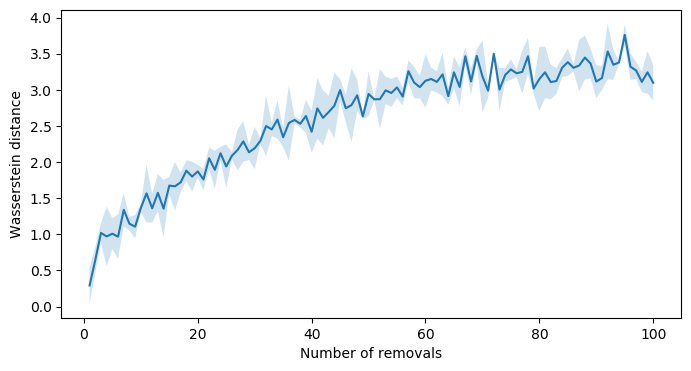

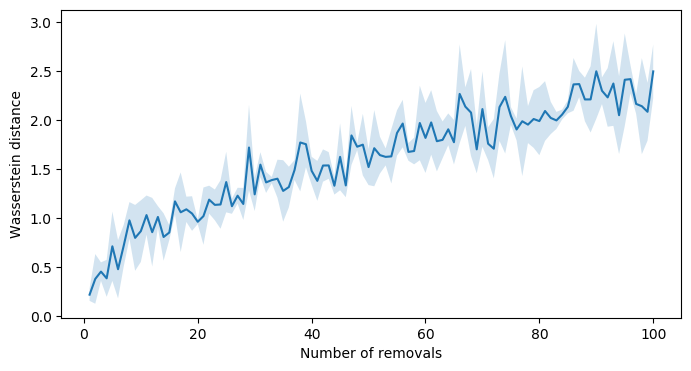

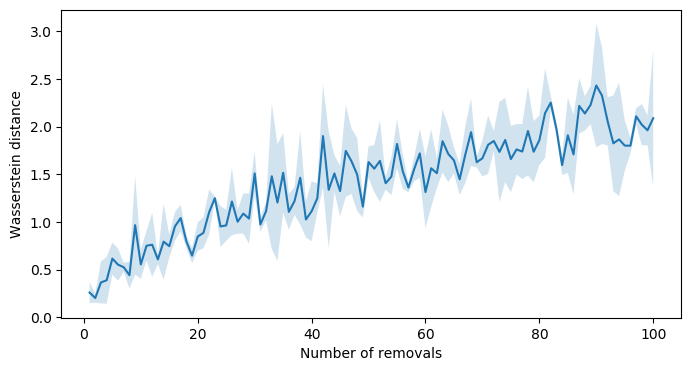

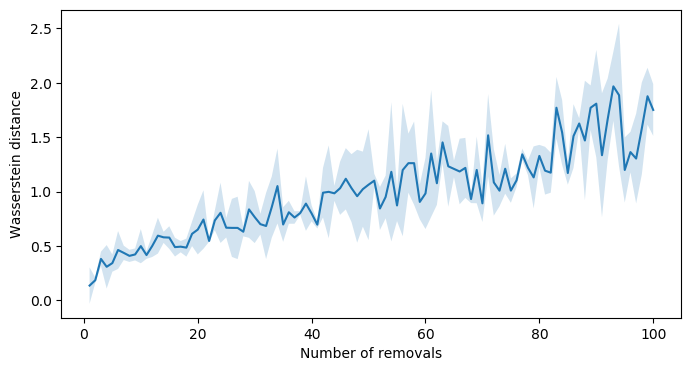

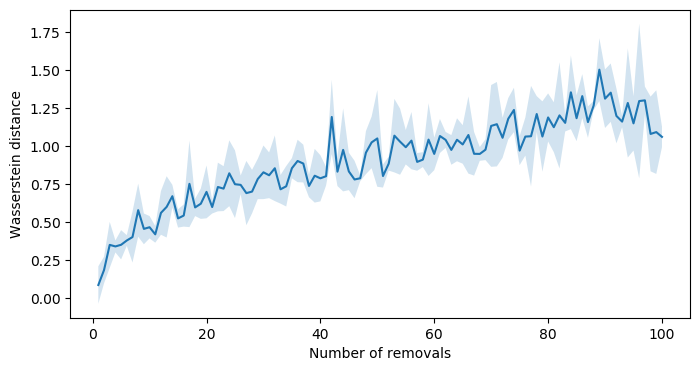

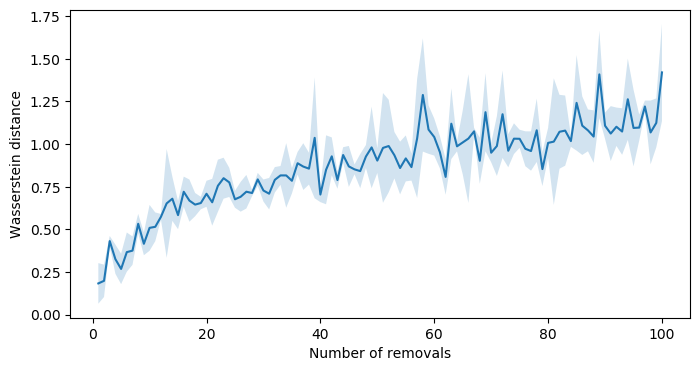

In [154]:
#clust
for i in 1:sz
    xs = convert(Array, 1:num_removals)
    lb = collect(Iterators.flatten(convert(Array, cmeanarray[i]-cstdarray[i])))
    ub = collect(Iterators.flatten(convert(Array, cmeanarray[i]+cstdarray[i])))

    figure(figsize=(8,4))
    plot(1:num_removals, cmeanarray[i])
    ax = gca()
    fill_between(xs, lb, ub, alpha=0.2)
    xlabel("Number of removals")
    ylabel("Wasserstein distance")
end

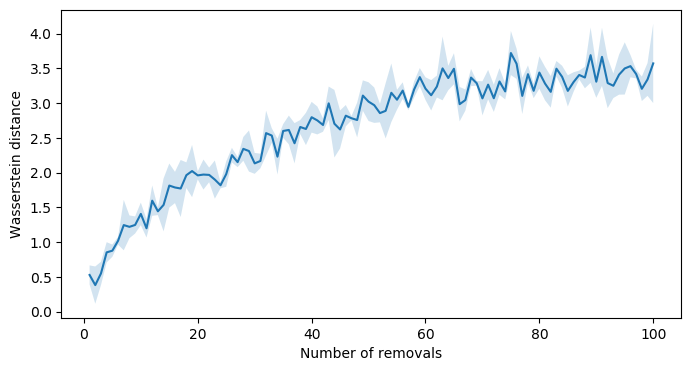

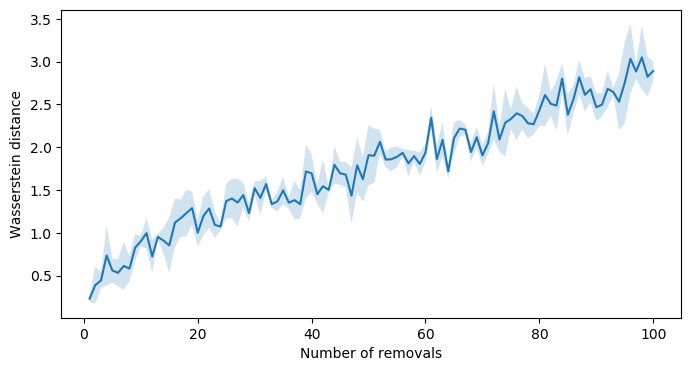

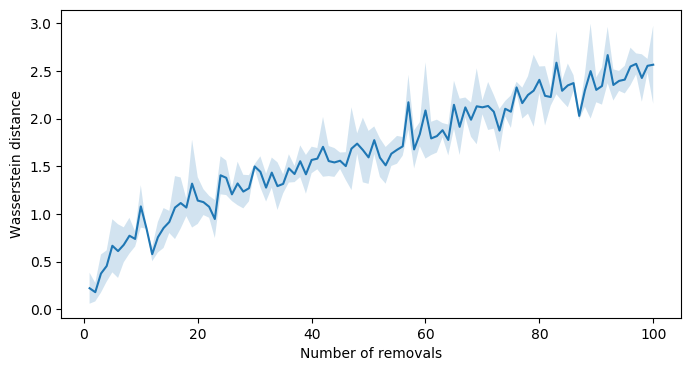

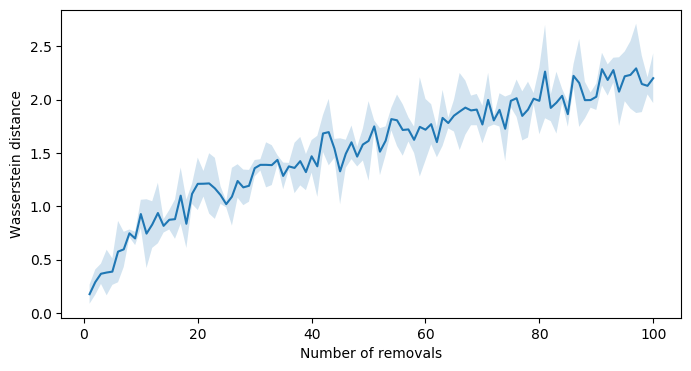

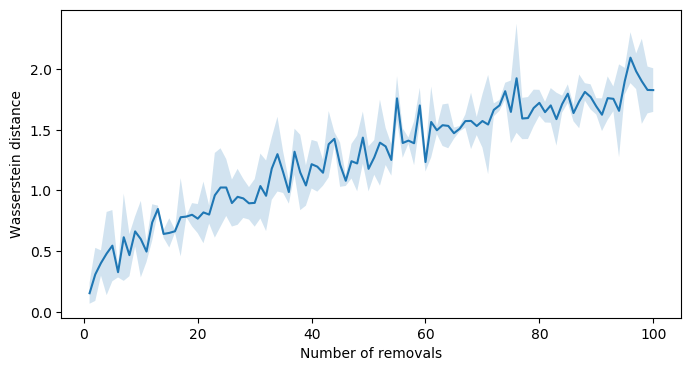

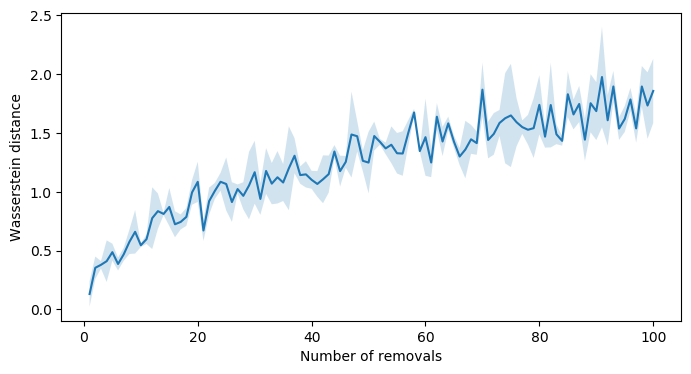

In [155]:
#span
for i in 1:sz
    xs = convert(Array, 1:num_removals)
    lb = collect(Iterators.flatten(convert(Array, smeanarray[i]-sstdarray[i])))
    ub = collect(Iterators.flatten(convert(Array, smeanarray[i]+sstdarray[i])))

    figure(figsize=(8,4))
    plot(1:num_removals, smeanarray[i])
    ax = gca()
    fill_between(xs, lb, ub, alpha=0.2)
    xlabel("Number of removals")
    ylabel("Wasserstein distance")
end

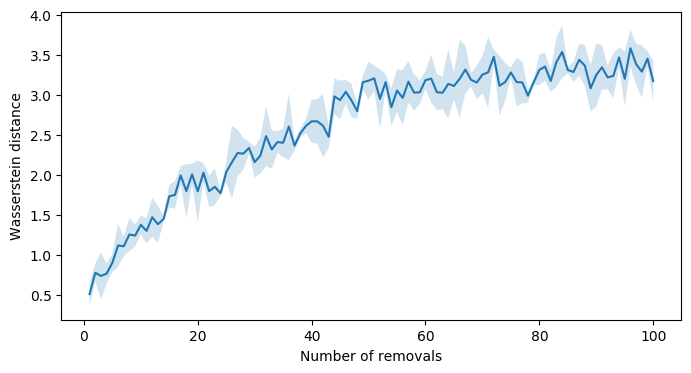

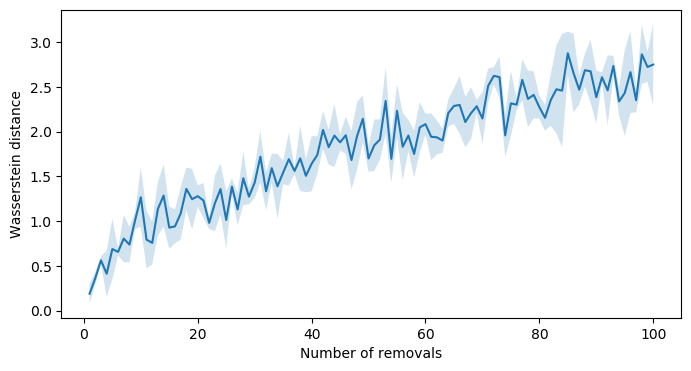

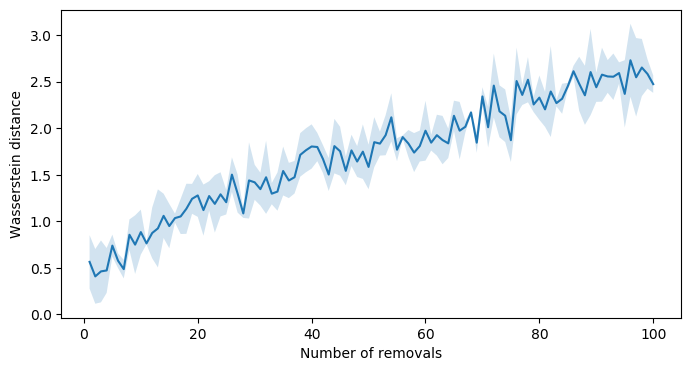

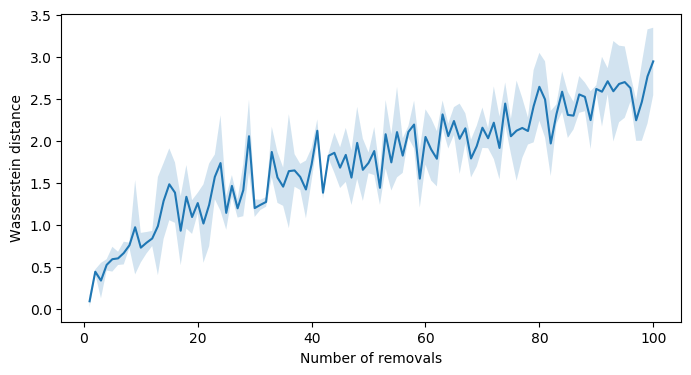

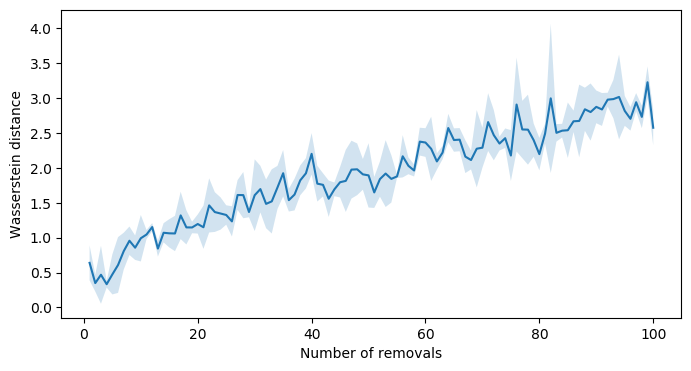

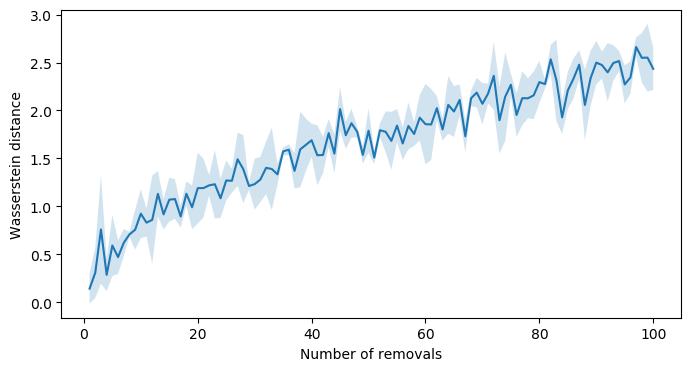

In [156]:
#indiv
for i in 1:sz
    xs = convert(Array, 1:num_removals)
    lb = collect(Iterators.flatten(convert(Array, imeanarray[i]-istdarray[i])))
    ub = collect(Iterators.flatten(convert(Array, imeanarray[i]+istdarray[i])))

    figure(figsize=(8,4))
    plot(1:num_removals, imeanarray[i])
    ax = gca()
    fill_between(xs, lb, ub, alpha=0.2)
    xlabel("Number of removals")
    ylabel("Wasserstein distance")
end

100×1 Array{Float64,2}:
 2.4237334961794788
 2.4237334961794788
 2.4237334961794788
 2.4237334961794788
 2.4237334961794788
 2.4237334961794788
 2.4237334961794788
 2.4237334961794788
 2.4237334961794788
 2.4237334961794788
 2.4237334961794788
 2.4237334961794788
 2.4237334961794788
 ⋮                 
 2.4237334961794788
 2.4237334961794788
 2.4237334961794788
 2.4237334961794788
 2.4237334961794788
 2.4237334961794788
 2.4237334961794788
 2.4237334961794788
 2.4237334961794788
 2.4237334961794788
 2.4237334961794788
 2.4237334961794788

In [102]:
xs = convert(Array, 1:num_removals)
lb = collect(Iterators.flatten(convert(Array, mean_ws_dist-std_ws_dist)))
ub = collect(Iterators.flatten(convert(Array, mean_ws_dist+std_ws_dist)))

figure(figsize=(8,4))
plot(1:num_removals, mean_ws_dist)
ax = gca()
fill_between(xs, lb, ub, alpha=0.2)
xlabel("Number of removals")
ylabel("Wasserstein distance")

UndefVarError: UndefVarError: mean_ws_dist not defined

In [120]:
size(clusterbarcodes)

(6,)